In [1]:
import numpy.random as dist
import numpy as np


In [2]:
def sample_exponential(num_samples=100, num_repetitions=1, λ=1):
    """ Sample from exponential distribution with parameter λ.

    Args:
        num_samples (int, optional): Number of independent samples. Defaults to 100.

    Returns:
        np.array: column vector of samples of size [num_samples, 1]
    """
    return dist.exponential(λ, [num_samples, num_repetitions])

def compute_sample_average(samples):
    """ Compute the sample average of a column vector.

    Args:
        samples (np.array): column vector of samples, size [num_samples, 1]

    Returns:
        np.float64: sample average
    """
    return np.mean(samples, 0)

def compute_sample_variance(samples):
    """ Compute the sample variance of a column vector.

    Args:
        samples (np.array): column vector of samples, size [num_samples, 1]

    Returns:
        np.float64: sample variance
    """
    return np.var(samples, 0)

In [3]:

num_samples     = 1000
num_repetitions = 10000

samples = sample_exponential(num_samples, num_repetitions)

f_ave = compute_sample_average(samples)
f_var = compute_sample_variance(f_ave)


In [4]:
def compute_chebyshev_prob(f_ave, π_f=1, ε=1e-2):
    n      = f_ave.shape[0]
    P_cheb = np.sum(np.abs(f_ave - π_f)>ε)/n
    return P_cheb

def compute_numerical_bound(f_ave_var, ε=1e-2):
    P_bound_meas = f_ave_var/(ε**2)
    return P_bound_meas

def compute_theoretical_bound(σ2=1, ε=1e-2, n=1000):
    P_bound_theo = σ2/(n * ε**2)
    return P_bound_theo

In [5]:
# by chebyshev
ε   = 1e-4
π_f = 1
σ2  = 1

P_chebyshev  = []
P_num_bound  = []
P_theo_bound = []

epsilons = np.linspace(1e-4, 1e-1, 300)

for εi in epsilons:
    P_chebyshev.append(compute_chebyshev_prob(f_ave, π_f, εi))
    P_num_bound.append(compute_numerical_bound(f_var, εi))
    P_theo_bound.append(compute_theoretical_bound(σ2, εi, num_samples))


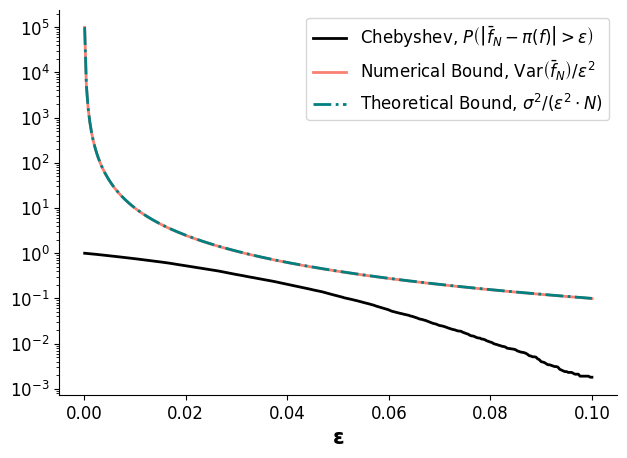

In [6]:
import matplotlib.pyplot as plt
from plot_utils import *
import os

fig, ax = plt.subplots(1, 1, figsize=(7.2, 5))

ax.plot(epsilons, P_chebyshev,  lw=2, ls="-",  color="k",      label  = r'Chebyshev, $P\left(\left|\bar{f}_N-\pi(f)\right|>\epsilon\right)$')
ax.plot(epsilons, P_num_bound,  lw=2, ls="-",  color="salmon", label  = r'Numerical Bound, $\mathrm{Var}\left(\bar{f}_N\right)/\epsilon^2$')
ax.plot(epsilons, P_theo_bound, lw=2, ls="-.", color="teal",   label = r'Theoretical Bound, $\sigma^2/(\epsilon^2\cdot N)$')

ax.set_yscale('log')
ax.set_xlabel(r'$\mathbf{ε}$')
ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig(os.path.join(".", "prob01_WLLN.png"),
                                            dpi=300, transparent=True, bbox_inches='tight')


## Central Limit Theorem

In [7]:
def sample_normal(num_samples=100, μ=0, σ=1):
    """ Sample from normal distribution with parameters μ and σ.

    Args:
        num_samples (int, optional): Number of independent samples. Defaults to 100.

    Returns:
        np.array: column vector of samples of size [num_samples, 1]
    """
    return dist.normal(μ, σ, [num_samples])

def normal_distribution(x, μ=0, σ=1):
    return (1/(σ*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-μ)/σ)**2)


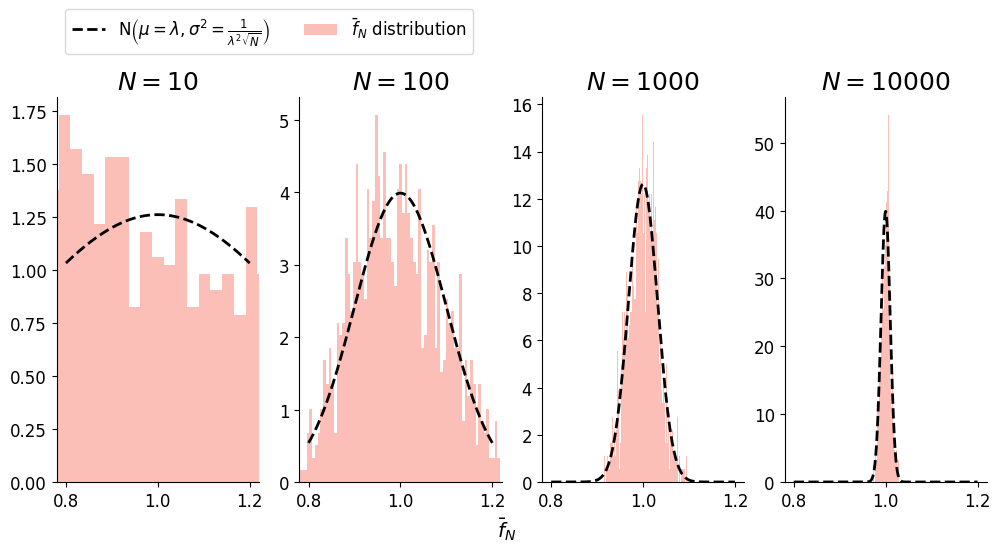

In [8]:

λ = 1
x = np.linspace(0.8, 1.2, 1000)


fig, ax = plt.subplots(1, 4, figsize=(12, 5))

for i, num_samples in enumerate([10, 100, 1000, 10000]):

    num_samples = int(num_samples)

    num_repetitions = int(1000)
    exp_samples     = sample_exponential(num_samples, num_repetitions)
    f_ave           = compute_sample_average(exp_samples)

    f_clt = sample_normal(num_samples=int(1e6), μ=λ, σ=(1/λ**2)/np.sqrt(num_samples))
    Xn    = normal_distribution(x, μ=λ, σ=(1/λ**2)/np.sqrt(num_samples))


    ax[i].plot(x, Xn, lw=2, ls="--", color="k", label=r'$\mathrm{N}\left(\mu=\lambda, \sigma^2=\frac{1}{\lambda^2\sqrt{N}}\right)$')
    ax[i].hist(f_ave, bins=100, density=True, color="salmon", alpha=0.5, label=r'$\bar{f}_N$ distribution')

    ax[i].set_title(r'$N={}$'.format(num_samples))

for axi in ax:
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_xlim((0.78, 1.22))

ax[0].legend(loc='upper left', bbox_to_anchor=(0.0, 1.25), ncol=2)

fig.supxlabel(r'$\bar{f}_N$', y=-.01)

fig.savefig(os.path.join(".", "prob01_CLT.png"),
                                            dpi=300, transparent=True, bbox_inches='tight')


In [23]:
def crps(pred_samples, truth):
    num_samples = pred_samples.shape[0]
    pred   = np.sort(pred_samples)
    diff   = pred[1:] - pred[:-1]
    weight = np.arange(1, num_samples) * np.arange( num_samples - 1, 0, -1)

    return np.abs(pred - truth).mean(0) - (diff * weight).sum(0) / num_samples**2

def Kullback_Leibler(p, q):
    kl = p*np.log(p/q)
    return kl[np.isfinite(kl)].sum()

In [24]:
import tqdm

In [86]:
num_samples_arr = np.logspace(1.0, 5.0, num=30)

Var_f        = np.full(num_samples_arr.shape, np.nan)
error_f      = np.full(num_samples_arr.shape, np.nan)
error_normal = np.full(num_samples_arr.shape, np.nan)

error_clt = np.full(num_samples_arr.shape, np.nan)

bins      = np.linspace(0.75, 1.25, 1000)

i = 0
for num_samples in tqdm.tqdm(num_samples_arr):

    num_samples = int(num_samples)

    num_repetitions = int(1000)
    exp_samples     = sample_exponential(num_samples, num_repetitions)


    f_ave       = compute_sample_average(exp_samples)
    f_clt       = sample_normal(num_samples=int(num_samples), μ=λ, σ=(1/λ**2)/np.sqrt(num_samples))

    Var_f[i]     = np.var(f_ave)


    error_f[i]      = crps(f_ave, np.array([1]))
    error_normal[i] = crps(f_clt, np.array([1]))

    p_f_ave, _ = np.histogram(f_ave, bins=bins)
    p_f_sim, _ = np.histogram(f_clt, bins=bins)

    error_clt[i] = Kullback_Leibler(p_f_ave, p_f_sim)

    Xn       = normal_distribution(x, μ=λ, σ=(1/λ**2)/np.sqrt(num_samples))
    i += 1

  0%|          | 0/30 [00:00<?, ?it/s]/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_70116/2318093929.py:10: RuntimeWarning: divide by zero encountered in divide
  kl = p*np.log(p/q)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_70116/2318093929.py:10: RuntimeWarning: invalid value encountered in divide
  kl = p*np.log(p/q)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_70116/2318093929.py:10: RuntimeWarning: divide by zero encountered in log
  kl = p*np.log(p/q)
/var/folders/20/x0sn0k_10hqfn739thwg8lxw0000gn/T/ipykernel_70116/2318093929.py:10: RuntimeWarning: invalid value encountered in multiply
  kl = p*np.log(p/q)
100%|██████████| 30/30 [00:03<00:00,  8.23it/s] 


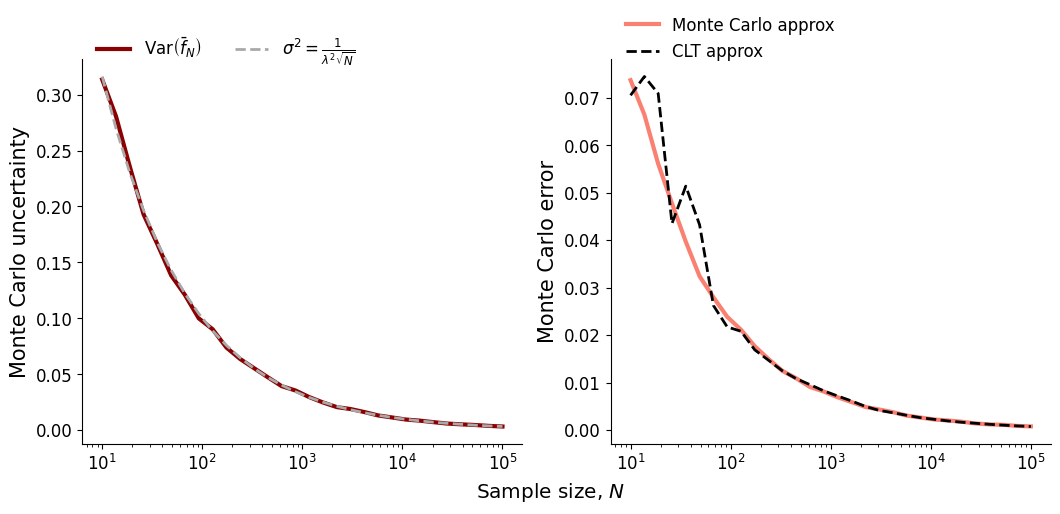

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(12.5, 5), sharex=True)

ax[0].plot(num_samples_arr, np.sqrt(Var_f), lw=3, ls="-",  color="darkred", label=r'$\mathrm{Var}\left(\bar{f}_N\right)$')
ax[0].plot(num_samples_arr, (1/λ**2)/np.sqrt(num_samples_arr), lw=2, ls="--",  color="darkgrey", label=r'$\sigma^2=\frac{1}{\lambda^2\sqrt{N}}$')

ax[1].plot(num_samples_arr, error_f, lw=3, ls="-",  color="salmon", label=r'Monte Carlo approx')
ax[1].plot(num_samples_arr, error_normal, lw=2, ls="--",  color="k", label=r'CLT approx')

ax[0].set_xscale('log')
ax[0].set_ylabel(r'Monte Carlo uncertainty')

ax[1].set_ylabel(r'Monte Carlo error')


ax[0].legend(loc="upper left", ncol=2, frameon=False, bbox_to_anchor=(0.0, 1.1))
ax[1].legend(loc="upper left", ncol=1, frameon=False, bbox_to_anchor=(0.0, 1.15))

#ax[2].plot(num_samples_arr, error_clt, lw=2, ls="-",  color="teal", label=r'$KL\left(MC\left(\bar{f}_N\right), \mathcal{N}\left(\mu=\lambda, \sigma^2=\frac{1}{\lambda^2\sqrt{N}}\right)\right)$')
#ax[2].legend(loc="upper left",  bbox_to_anchor=(0.0, 1.1), frameon=False)
#ax[2].set_ylabel(r'CLT error')

for axi in ax:
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

fig.supxlabel(r'Sample size, $N$', y=-.01)


fig.savefig(os.path.join(".", "prob01_MC-CLT_error.png"),
                                            dpi=300, transparent=True, bbox_inches='tight')


# Concentration inequality

In [189]:
def Ia(f_bar=1, pi_f=1, a=1e-3, λ=1):

    ldp_o  = λ*a - np.log(np.mean(np.exp(λ*(f_bar - pi_f))))

    return np.max(ldp_o)

def compute_chernoff_prob(f_ave, π_f=1, a=1e-2):
    n      = f_ave.shape[0]

    P_cher = np.sum(f_ave - π_f>=a)/n
    return P_cher

In [238]:
num_samples     = 1000
num_repetitions = 1000

π_f          = 1
exp_samples  = sample_exponential(num_samples, num_repetitions)

epsilon = np.linspace(1e-3, 0.05, 100)

P_chernoff   = np.full(epsilon.shape, np.nan)
P_cher_bound = np.full(epsilon.shape, np.nan)

λ = 0.01

for i, εi in enumerate(epsilon):

    P_chernoff[i]   = compute_chernoff_prob(f_ave, π_f, a=εi)
    P_cher_bound[i] = np.exp(-num_samples*Ia(f_ave, π_f, a=εi, λ=λ))


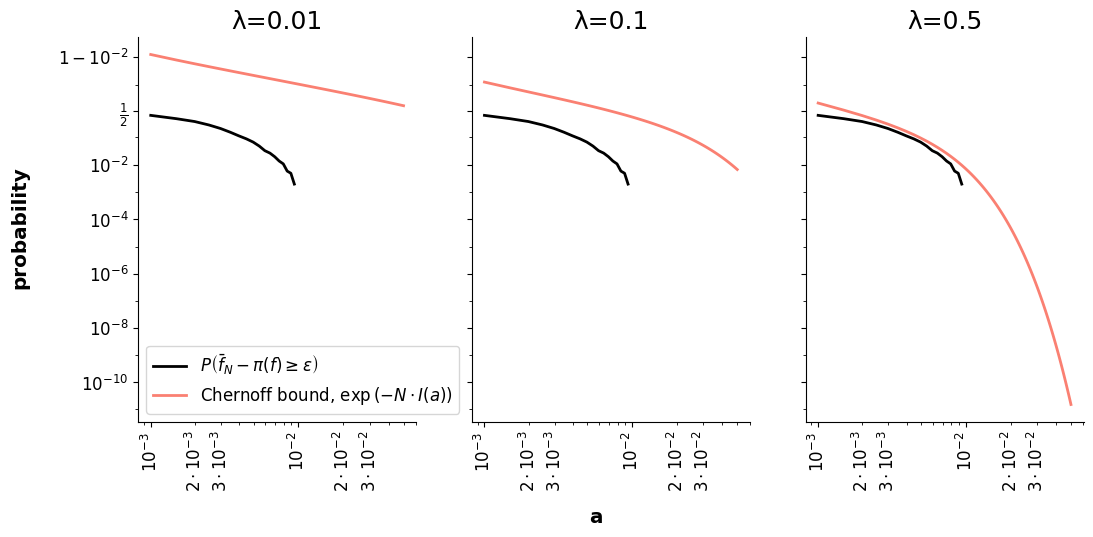

In [263]:
fig, ax = plt.subplots(1, 3, figsize=(12.2, 5), sharex=True, sharey=True)

for il, λ in enumerate([0.01, 0.1, 0.5]):
    P_chernoff   = np.full(epsilon.shape, np.nan)
    P_cher_bound = np.full(epsilon.shape, np.nan)

    for i, εi in enumerate(epsilon):

        P_chernoff[i]   = compute_chernoff_prob(f_ave, π_f, a=εi)
        P_cher_bound[i] = np.exp(-num_samples*Ia(f_ave, π_f, a=εi, λ=λ))

    ax[il].plot(epsilon, P_chernoff,  lw=2, ls="-",  color="k",      label  = r'$P\left( \bar{f}_N-\pi(f)\geq \epsilon\right)$')
    ax[il].plot(epsilon, P_cher_bound,  lw=2, ls="-",  color="salmon", label  = r'Chernoff bound, $\exp\left(-N\cdot I(a)\right)$')

    ax[il].set_title("λ={}".format(λ))

for axi in ax.flatten():
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.set_yscale('logit')
    axi.set_xscale('logit')


fig.supylabel(r'probability', weight="bold")
fig.supxlabel(r'$\mathbf{a}$', y=-0.1)

ax[0].legend(loc="lower left",  frameon=True, ncol=1)

ax[0].tick_params(axis='x', which="both", labelrotation=90)
ax[1].tick_params(axis='x', which="both", labelrotation=90)
ax[2].tick_params(axis='x', which="both", labelrotation=90)

fig.savefig(os.path.join(".", "prob01_Chernoff.png"), dpi=300, transparent=True, bbox_inches='tight')
